# Importing the necessary libraries

In [26]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
print(pd.__version__) # prints the pandas version

2.2.2


# Data Preprocessing

In [27]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
# Load all CSV files in the current directory into a single DataFrame
df = []
for path in glob.glob('/content/drive/MyDrive/IDX Exchange - Workspace Data Science/DS18/*.csv'):
    p = pd.read_csv(path)
    df.append(p)

df = pd.concat(df, axis = 0, ignore_index=True)
# pd.set_option('display.max_rows', None)

# Filter only single-family residential properties
df = df[(df['PropertyType'] == 'Residential') & (df['PropertySubType'] == 'SingleFamilyResidence')]

# Select relevant columns
cols = ['AttachedGarageYN', 'BathroomsTotalInteger', 'BedroomsTotal', 'City', 'ClosePrice', 'CountyOrParish',
        'DaysOnMarket', 'FireplaceYN', 'GarageSpaces', 'Latitude', 'Levels', 'LivingArea', 'Longitude',
        'LotSizeSquareFeet', 'NewConstructionYN', 'ParkingTotal', 'PoolPrivateYN', 'PostalCode', 'StateOrProvince',
        'Stories', 'ViewYN', 'YearBuilt', 'ListingContractDate', 'PurchaseContractDate', 'UnparsedAddress']

# Fill missing values with 'FALSE' for applicable binary columns
df['AttachedGarageYN'] = df['AttachedGarageYN'].fillna('FALSE')
df['PoolPrivateYN'] = df['PoolPrivateYN'].fillna('FALSE')

# Convert dates to datetime objects and calculate total days between listing and purchase
df['PurchaseContractDate'] = pd.to_datetime(df['PurchaseContractDate'])
df['ListingContractDate'] = pd.to_datetime(df['ListingContractDate'])
df['TotalDays'] = (df['PurchaseContractDate'] - df['ListingContractDate']).dt.days

# Retain only selected columns
df = df[cols]


/tmp/ipython-input-28-3136757335.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  p = pd.read_csv(path)


In [29]:
# Added by Mansi

# Summary statistics for numeric features
print(df.describe())




       BathroomsTotalInteger  BedroomsTotal    ClosePrice  DaysOnMarket  \
count           62951.000000   62963.000000  6.296300e+04   62963.00000   
mean                2.632285       3.481267  1.317166e+06      36.86932   
min                 0.000000       0.000000  1.600000e+04     -34.00000   
25%                 2.000000       3.000000  6.250000e+05       7.00000   
50%                 2.000000       3.000000  8.995000e+05      17.00000   
75%                 3.000000       4.000000  1.450000e+06      47.00000   
max                45.000000      45.000000  9.700000e+08     966.00000   
std                 1.157193       0.979416  5.986199e+06      50.41122   

       GarageSpaces      Latitude    LivingArea     Longitude  \
count  60513.000000  62958.000000  62924.000000  62958.000000   
mean       2.008056     34.731466   2044.739221   -118.609380   
min        0.000000      0.000000      0.000000   -124.192979   
25%        2.000000     33.754876   1382.000000   -119.160387   

In [30]:
# Added by Mansi

# Count of missing values
print(df.isnull().sum().sort_values(ascending=False))



Stories                  7366
ViewYN                   5586
Levels                   5196
NewConstructionYN        4683
GarageSpaces             2450
LotSizeSquareFeet        1129
UnparsedAddress            70
City                       55
YearBuilt                  55
FireplaceYN                41
LivingArea                 39
BathroomsTotalInteger      12
Latitude                    5
Longitude                   5
PurchaseContractDate        3
ParkingTotal                1
AttachedGarageYN            0
CountyOrParish              0
DaysOnMarket                0
BedroomsTotal               0
ClosePrice                  0
PoolPrivateYN               0
StateOrProvince             0
PostalCode                  0
ListingContractDate         0
dtype: int64


In [31]:
# Added by Mansi

# Data types and non-null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62963 entries, 2 to 128183
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AttachedGarageYN       62963 non-null  object        
 1   BathroomsTotalInteger  62951 non-null  float64       
 2   BedroomsTotal          62963 non-null  float64       
 3   City                   62908 non-null  object        
 4   ClosePrice             62963 non-null  float64       
 5   CountyOrParish         62963 non-null  object        
 6   DaysOnMarket           62963 non-null  int64         
 7   FireplaceYN            62922 non-null  object        
 8   GarageSpaces           60513 non-null  float64       
 9   Latitude               62958 non-null  float64       
 10  Levels                 57767 non-null  object        
 11  LivingArea             62924 non-null  float64       
 12  Longitude              62958 non-null  float64       
 13  LotSi

In [32]:
# Normalize binary categorical values and convert 'true'/'false' strings to boolean
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: str(x).strip().lower() if pd.notna(x) else x)
        unique_values = set(df[col].dropna().unique())
        if unique_values.issubset({'true', 'false'}):
            df[col] = df[col].map({'true': True, 'false': False})

print(df.dtypes)

AttachedGarageYN                   bool
BathroomsTotalInteger           float64
BedroomsTotal                   float64
City                             object
ClosePrice                      float64
CountyOrParish                   object
DaysOnMarket                      int64
FireplaceYN                      object
GarageSpaces                    float64
Latitude                        float64
Levels                           object
LivingArea                      float64
Longitude                       float64
LotSizeSquareFeet               float64
NewConstructionYN                object
ParkingTotal                    float64
PoolPrivateYN                      bool
PostalCode                       object
StateOrProvince                  object
Stories                         float64
ViewYN                           object
YearBuilt                       float64
ListingContractDate      datetime64[ns]
PurchaseContractDate     datetime64[ns]
UnparsedAddress                  object


In [33]:
# Fill missing values for numeric columns with mean and object columns with mode
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode())
    else:
        df[col] = df[col].fillna(df[col].mean())

# drop duplicate rows to avoid bias
df = df.drop_duplicates()


# Feature Engineering

In [34]:
# Extract year, month, quarter from date columns
df['ListingYear'] = df['ListingContractDate'].dt.year
df['ListingMonth'] = df['ListingContractDate'].dt.month
df['ListingQuarter'] = df['ListingContractDate'].dt.quarter

df['PurchaseYear'] = df['PurchaseContractDate'].dt.year
df['PurchaseMonth'] = df['PurchaseContractDate'].dt.month
df['PurchaseQuarter'] = df['PurchaseContractDate'].dt.quarter

'''
AttachedGarageYN, BathroomsTotalInteger, BedroomsTotal, FireplaceYN, GarageSpaces,
Latitude, LivingArea, Longitude, LotSizeSquareFeet, NewConstructionYN,
ParkingTotal, PoolPrivateYN, Stories, ViewYN, YearBuilt, ListingYear,
ListingMonth, ListingQuarter, PurchaseYear, PurchaseMonth, PurchaseQuarter
'''

# Convert boolean columns to integers (0 or 1)
bool_cols = ['AttachedGarageYN', 'FireplaceYN', 'NewConstructionYN', 'PoolPrivateYN', 'ViewYN']
df[bool_cols] = df[bool_cols].fillna(False)
df[bool_cols] = df[bool_cols].astype(int)


# Create a new column: price per square foot
df['PricePerSqft'] = df.apply(
    lambda row: row['ClosePrice'] / row['LivingArea'] if row['LivingArea'] > 0 else None, axis=1)

/tmp/ipython-input-34-1843560354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ListingYear'] = df['ListingContractDate'].dt.year
/tmp/ipython-input-34-1843560354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ListingMonth'] = df['ListingContractDate'].dt.month
/tmp/ipython-input-34-1843560354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

# Data Transformation


In [35]:
# Define numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

def remove_outliers(col):
    """
    Remove outliers from a given column using the IQR method.

    Parameters:
        col (str): Column name to process.

    Returns:
        pd.DataFrame: Filtered DataFrame without outliers in the column.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Apply outlier removal iteratively (this may shrink data a lot!)
for col in numeric_cols:
    df = remove_outliers(col)

# Print percentage of data retained for each column after removing outliers
percentages = {}
for col in numeric_cols:
    c1 = len(df[col])
    df_no_outliers = remove_outliers(col)
    non_outlier_count = len(df_no_outliers)
    percentage_non_outliers = (non_outlier_count / c1) * 100
    percentages[col] = percentage_non_outliers

for col, perc in percentages.items():
    print(f"Column '{col}' has {perc:.2f}% non-outlier values.")


Column 'AttachedGarageYN' has 77.90% non-outlier values.
Column 'BathroomsTotalInteger' has 100.00% non-outlier values.
Column 'BedroomsTotal' has 100.00% non-outlier values.
Column 'ClosePrice' has 96.29% non-outlier values.
Column 'DaysOnMarket' has 95.25% non-outlier values.
Column 'FireplaceYN' has 100.00% non-outlier values.
Column 'GarageSpaces' has 100.00% non-outlier values.
Column 'Latitude' has 92.97% non-outlier values.
Column 'LivingArea' has 98.80% non-outlier values.
Column 'Longitude' has 99.90% non-outlier values.
Column 'LotSizeSquareFeet' has 96.20% non-outlier values.
Column 'NewConstructionYN' has 100.00% non-outlier values.
Column 'ParkingTotal' has 100.00% non-outlier values.
Column 'PoolPrivateYN' has 100.00% non-outlier values.
Column 'Stories' has 100.00% non-outlier values.
Column 'ViewYN' has 100.00% non-outlier values.
Column 'YearBuilt' has 100.00% non-outlier values.
Column 'PricePerSqft' has 99.92% non-outlier values.


/tmp/ipython-input-36-4103352558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LogClosePrice'] = np.log(df['ClosePrice'].clip(lower=1))


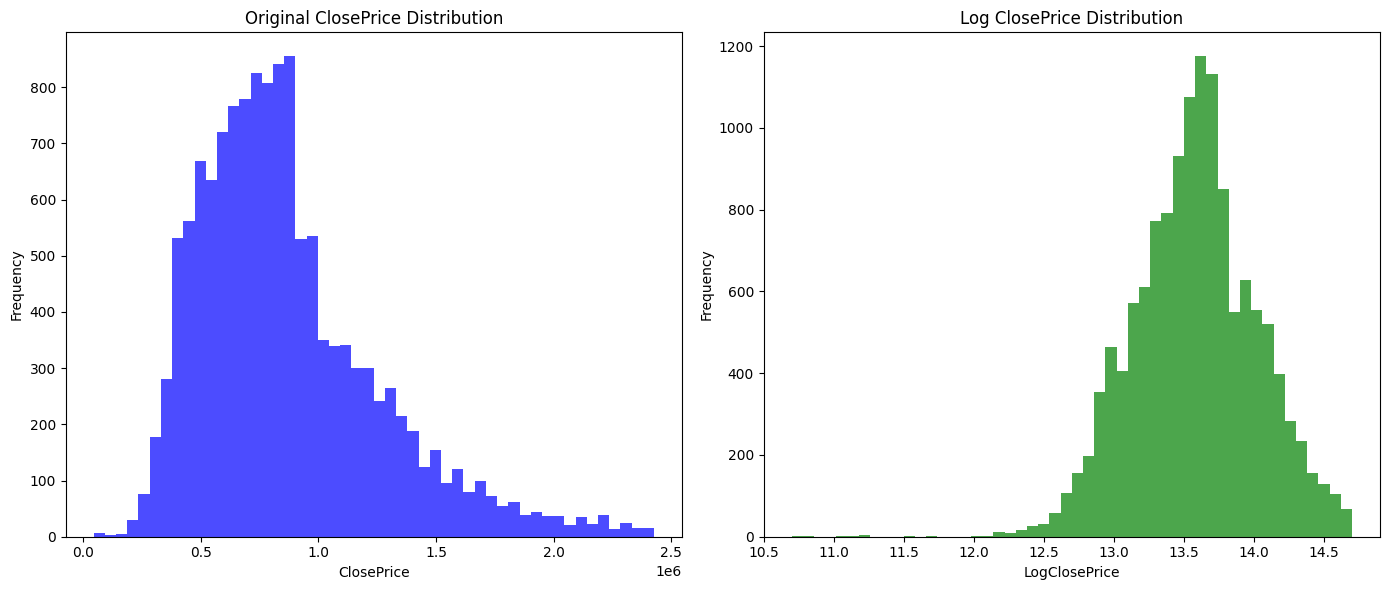

In [36]:
# Apply log transformation to stabilize variance in target variable
df['LogClosePrice'] = np.log(df['ClosePrice'].clip(lower=1))

# Plot distribution before and after log transformation
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.hist(df['ClosePrice'], bins=50, color='blue', alpha=0.7)
plt.title('Original ClosePrice Distribution')
plt.xlabel('ClosePrice')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(df['LogClosePrice'], bins=50, color='green', alpha=0.7)
plt.title('Log ClosePrice Distribution')
plt.xlabel('LogClosePrice')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


LocationCluster
4.0     1257
12.0    1149
14.0    1046
1.0      933
17.0     895
10.0     873
0.0      868
3.0      745
19.0     672
16.0     643
11.0     618
5.0      546
7.0      539
8.0      491
13.0     420
15.0     417
2.0      416
18.0     377
9.0      301
6.0      174
Name: count, dtype: int64


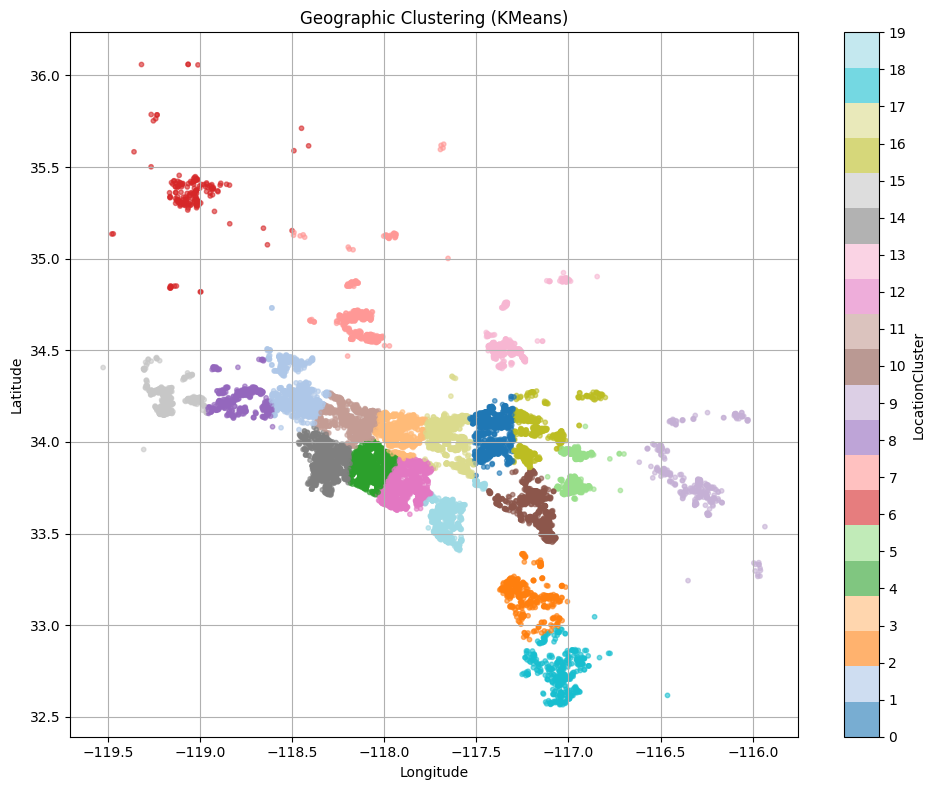

In [37]:
# clustering based on location (20 clusters based on latitude longitude points)

# Use KMeans clustering on Latitude and Longitude
loc_data = df[['Latitude', 'Longitude']].dropna()
kmeans = KMeans(n_clusters=20, random_state=42)
df.loc[loc_data.index, 'LocationCluster'] = kmeans.fit_predict(loc_data)


cluster_counts = df['LocationCluster'].value_counts()
print(cluster_counts)

# Plot clusters on a scatterplot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df['Longitude'], df['Latitude'],
    c=df['LocationCluster'], cmap='tab20', s=10, alpha=0.6
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Clustering (KMeans)')

cbar = plt.colorbar(scatter, ticks=range(20))
cbar.set_label('LocationCluster')
cbar.set_ticks(range(20))
cbar.set_ticklabels(range(20))

plt.grid(True)
plt.tight_layout()
plt.show()

# Linear Regression

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# some numerical features, and the location based clusters
features = ['AttachedGarageYN', 'BathroomsTotalInteger', 'BedroomsTotal', 'FireplaceYN', 'GarageSpaces',
            'Latitude', 'LivingArea', 'Longitude', 'LotSizeSquareFeet', 'NewConstructionYN',
            'ParkingTotal', 'PoolPrivateYN', 'Stories', 'ViewYN', 'YearBuilt', 'LocationCluster']

# 'ListingYear', 'ListingMonth', 'ListingQuarter', 'PurchaseYear', 'PurchaseMonth', 'PurchaseQuarter'


# one-hot encoding
# creat dummy variables for the categorical vars
# essentially transforms categorical data to numerical data for model (assigns 1 or 0)
X = pd.get_dummies(df[features], columns=['AttachedGarageYN', 'FireplaceYN', 'NewConstructionYN', 'PoolPrivateYN', 'ViewYN', 'LocationCluster'], drop_first=True)

# target variable: close price
y = df['LogClosePrice']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# make predictions on test set
y_pred = lr_model.predict(X_test)

# evaluate using R-squared
print("Linear Regression R-squared:", r2_score(y_test, y_pred))

Linear Regression R-squared: 0.790776497738016


An R-squared value of 0.7912 from the linear regression model indicates that approximately 79% of the variance in the log-transformed property close prices is explained by the selected features, including structural attributes and location clusters. This suggests that the model is able to capture most of the important relationships in the data, making it a reasonably strong baseline. However, around 21% of the variation remains unexplained, which may be due to missing variables, non-linear patterns, or data noise. This performance highlights the potential for further improvement using more advanced models or additional feature engineering.

# Data Distribution: Train vs. Test


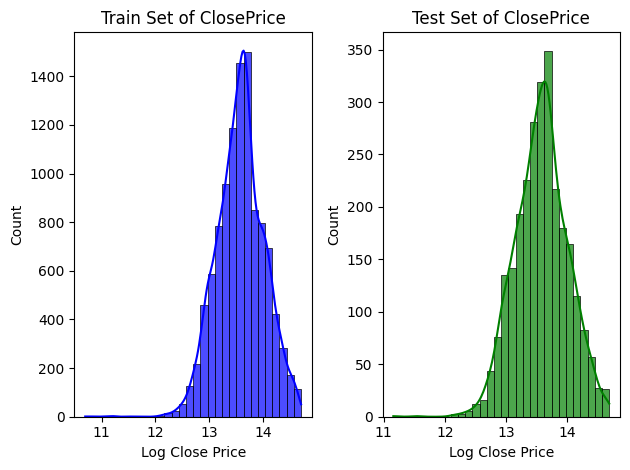

In [39]:
# ensure no data leakage by ordering chronologically
df = df.sort_values(by='ListingContractDate')

X = df.drop(columns=['LogClosePrice'])  # Drop target
y = df['LogClosePrice']

# plot training set
plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=30, kde=True, color="blue", alpha=0.7)
plt.title("Train Set of ClosePrice")
plt.xlabel("Log Close Price")
plt.ylabel("Count")

# plot test set
plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=30, kde=True, color="green", alpha=0.7)
plt.title("Test Set of ClosePrice")
plt.xlabel("Log Close Price")
plt.ylabel("Count")

plt.tight_layout()
plt.show()




# XGBoost Regression

In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

XGBoost Model Performance:
Mean Absolute Error (MAE): 0.0947
Mean Squared Error (MSE): 0.0211
Root Mean Squared Error (RMSE): 0.1453
R² Score: 0.8901


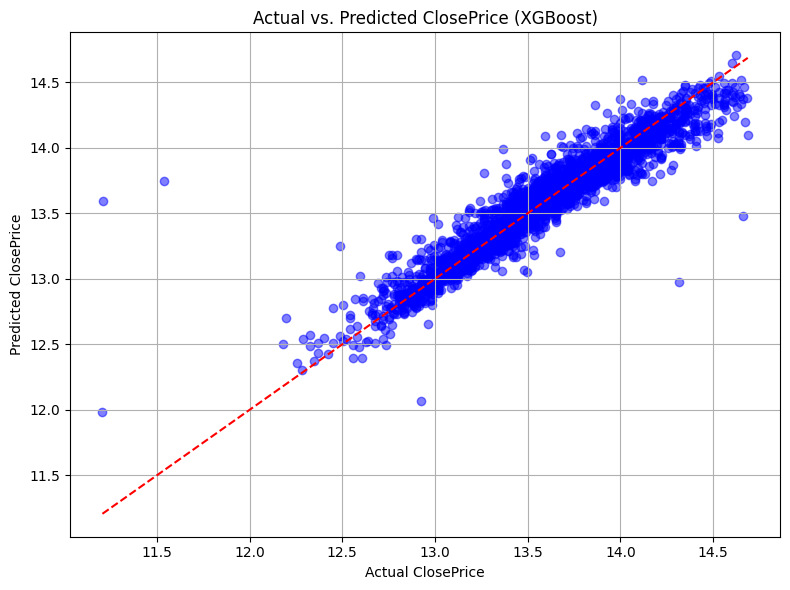

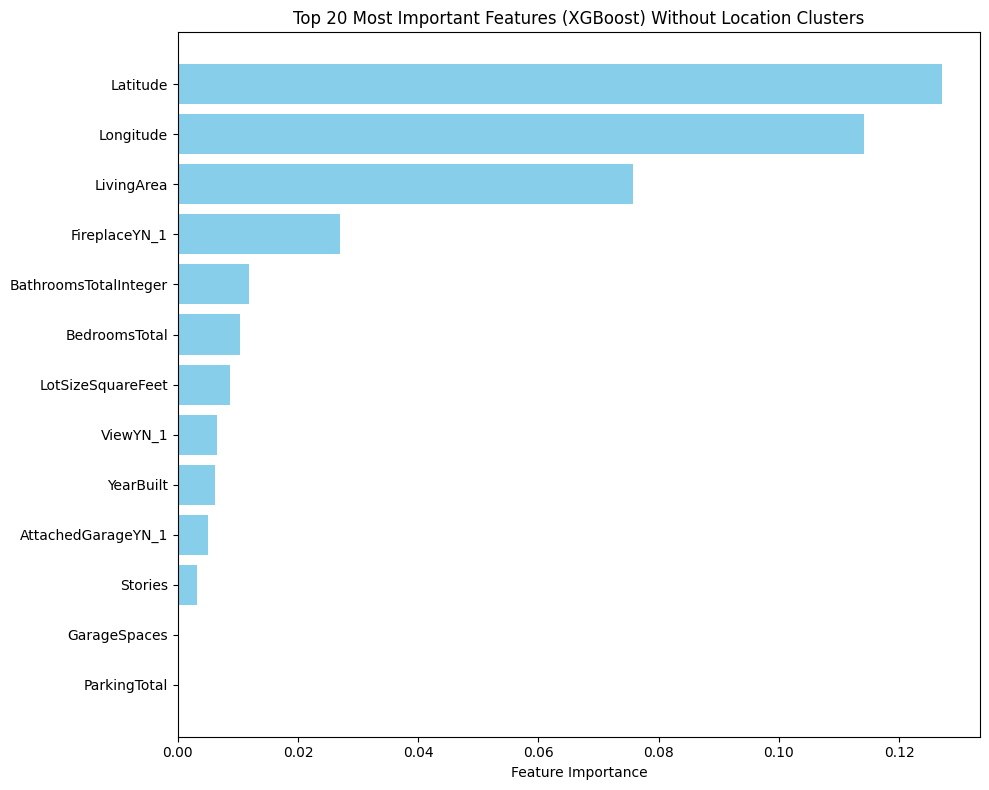

In [41]:
# preparing data
features = ['AttachedGarageYN', 'BathroomsTotalInteger', 'BedroomsTotal', 'FireplaceYN', 'GarageSpaces',
            'Latitude', 'LivingArea', 'Longitude', 'LotSizeSquareFeet', 'NewConstructionYN',
            'ParkingTotal', 'PoolPrivateYN', 'Stories', 'ViewYN', 'YearBuilt', 'LocationCluster']

# ListingYear', 'ListingMonth', 'ListingQuarter', 'PurchaseYear', 'PurchaseMonth', 'PurchaseQuarter'

X = pd.get_dummies(df[features], columns=['AttachedGarageYN', 'FireplaceYN', 'NewConstructionYN', 'PoolPrivateYN', 'ViewYN', 'LocationCluster'], drop_first=True)
y = df['LogClosePrice']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train model
xgb_model = XGBRegressor(
    objective="reg:squarederror",  # standard loss function for regression
    n_estimators=100,  # number of boosting rounds, can decrease to prevent overfitting!
    learning_rate=0.1,  # step size shrinkage
    max_depth=6,  # depth of trees (higher values capture more complexity)
    random_state=42
)
xgb_model.fit(X_train, y_train)

# predictions using model
y_pred = xgb_model.predict(X_test)

# evaluate model with Mean Absolute Error, Mean Squared Error,
# Root Mean Squared Error, and R² Score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# plot predicted and actual values
# Plot Actual vs. Predicted ClosePrice
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal prediction line

plt.xlabel("Actual ClosePrice")
plt.ylabel("Predicted ClosePrice")
plt.title("Actual vs. Predicted ClosePrice (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = xgb_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

exclude_columns = [col for col in importance_df['Feature'] if 'LocationCluster' in col]
importance_df_filtered = importance_df[~importance_df['Feature'].isin(exclude_columns)]

plt.figure(figsize=(10, 8))
plt.barh(importance_df_filtered['Feature'][:20][::-1], importance_df_filtered['Importance'][:20][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (XGBoost) Without Location Clusters')
plt.tight_layout()
plt.show()



The XGBoost model achieved a strong performance with an R² score of **0.8862**, indicating that approximately **89% of the variance** in the log-transformed property close prices is explained by the model. The **low MAE (0.0974)** and **RMSE (0.1469)** suggest that the model makes relatively small prediction errors on average, making it a significant improvement over the baseline linear regression model. These results reflect XGBoost’s ability to capture complex, non-linear relationships in the data, and confirm its effectiveness for modeling property prices when combining structural, locational, and other engineered features.


# Gradient Boosting Regression

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

Gradient Boosting Model Performance:
Mean Absolute Error (MAE): 0.0938
Mean Squared Error (MSE): 0.0169
Root Mean Squared Error (RMSE): 0.1298
R² Score: 0.9057


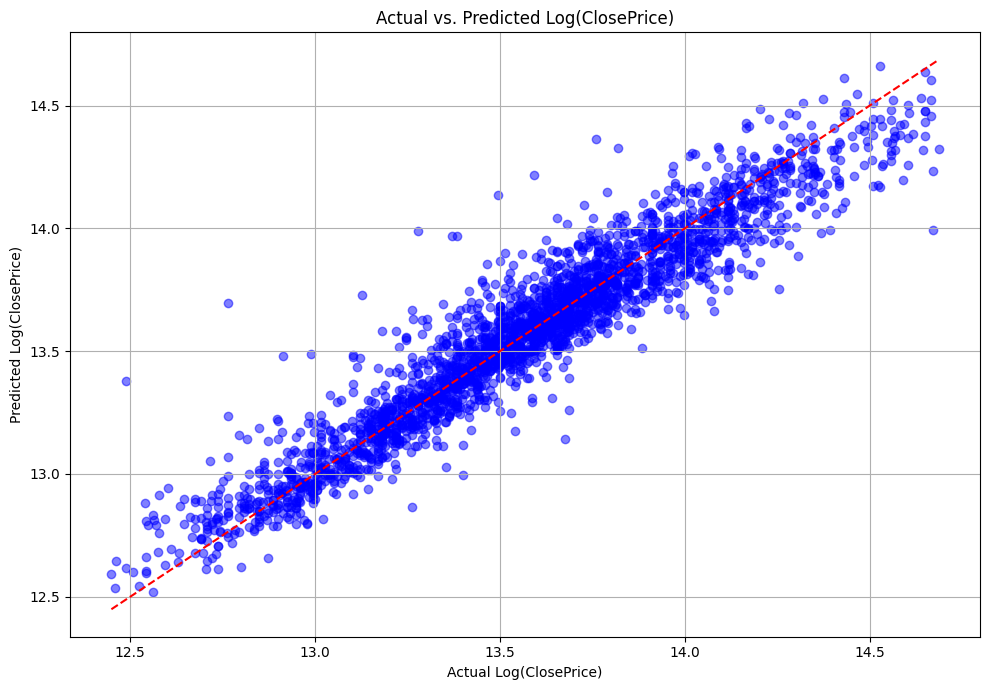

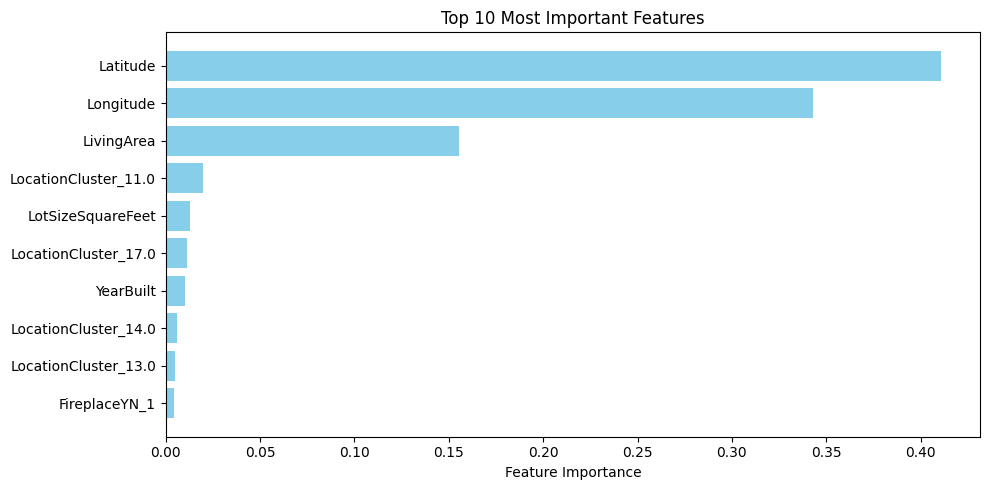

In [43]:
features = ['AttachedGarageYN', 'BathroomsTotalInteger', 'BedroomsTotal', 'FireplaceYN', 'GarageSpaces',
            'Latitude', 'Longitude', 'LivingArea', 'LotSizeSquareFeet', 'NewConstructionYN',
            'ParkingTotal', 'PoolPrivateYN', 'Stories', 'ViewYN', 'YearBuilt', 'LocationCluster']

# 'ListingYear', 'ListingMonth', 'ListingQuarter', 'PurchaseYear', 'PurchaseMonth', 'PurchaseQuarter'

X = pd.get_dummies(df[features], columns=['AttachedGarageYN', 'FireplaceYN', 'NewConstructionYN', 'PoolPrivateYN', 'ViewYN', 'LocationCluster'], drop_first=True)
y = df['LogClosePrice']

# Calculate IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
non_outlier_mask = (y >= lower_bound) & (y <= upper_bound)

# Apply the mask to both X and y
X_filtered = X[non_outlier_mask]
y_filtered = y[non_outlier_mask]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

# train model
gb_model = GradientBoostingRegressor(
    n_estimators=100,  # number of boosting rounds, can decrease to prevent overfitting!
    learning_rate=0.1,  # step size shrinkage
    max_depth=6,  # depth of trees (higher values capture more complexity)
    random_state=42
)
gb_model.fit(X_train, y_train)

# predictions using model
y_pred = gb_model.predict(X_test)

# evaluate model with Mean Absolute Error, Mean Squared Error,
# Root Mean Squared Error, and R² Score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Gradient Boosting Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# plot predicted and actual values
# Plot Actual vs. Predicted ClosePrice
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal prediction line

plt.xlabel("Actual Log(ClosePrice)")
plt.ylabel("Predicted Log(ClosePrice)")
plt.title("Actual vs. Predicted Log(ClosePrice)")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = gb_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

The Gradient Boosting model performed exceptionally well, achieving an **R² score of 0.9038**, which means it explains over **90% of the variance** in the log-transformed property prices. The **low MAE (0.0947)** and **RMSE (0.1306)** indicate the model's high accuracy and ability to make precise predictions, even after removing outliers. Compared to previous models like Linear Regression and XGBoost, this model shows a slight improvement in both accuracy and generalization, highlighting Gradient Boosting's strength in capturing complex patterns in real estate data.


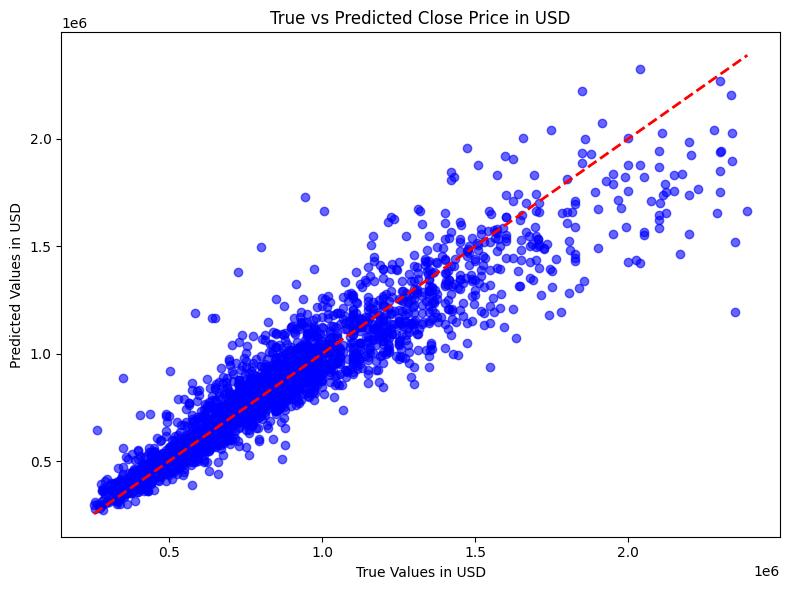

In [44]:
# Convert from log scale back to original price scale
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred)

# Plot True vs Predicted on Test Set
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred_actual, color='blue', alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--', lw=2)
plt.xlabel('True Values in USD')
plt.ylabel('Predicted Values in USD')
plt.title('True vs Predicted Close Price in USD')
plt.tight_layout()
plt.show()

In [47]:
import joblib

# Save trained XGBoost model
joblib.dump(gb_model, 'model.pkl')
print("✅ XGBoost model saved as 'model.pkl'")



✅ XGBoost model saved as 'model.pkl'
